Install dependencies

In [1]:
# !pip install transformers==4.36.2 torch --upgrade
# !pip install sentencepiece

Imports & device

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


Load dataset

In [3]:
data_path = "final_dataset.csv"  # change if needed

df = pd.read_csv(data_path)
df.head()

,id,rating,review,split
0,1,negative,overpriced food with terrible taste .,train
1,2,negative,waiting time was extremely long for a simple o...,val
2,3,negative,waiting time was extremely long for a simple o...,train
3,4,negative,the table was sticky and the cutlery was dirty .,val
4,5,positive,quick delivery and fresh ingredients .,train


Clean + Label Encode

In [4]:
df.columns = df.columns.str.strip()
df = df.dropna(subset=["review", "rating"])

df["rating"] = df["rating"].str.lower().str.strip()

label_map = {"negative": 0, "positive": 1}
df["label"] = df["rating"].map(label_map)

df.head()


,id,rating,review,split,label
0,1,negative,overpriced food with terrible taste .,train,0
1,2,negative,waiting time was extremely long for a simple o...,val,0
2,3,negative,waiting time was extremely long for a simple o...,train,0
3,4,negative,the table was sticky and the cutlery was dirty .,val,0
4,5,positive,quick delivery and fresh ingredients .,train,1


Setup tokenizer + Dataset class

In [5]:
PRETRAINED_MODEL = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=128):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        text = str(self.reviews[idx])
        label = int(self.labels[idx])

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "targets": torch.tensor(label, dtype=torch.long)
        }


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Create DataLoaders

In [6]:
MAX_LEN = 128
BATCH_SIZE = 16

df_train = df[df.split == "train"].reset_index(drop=True)
df_val = df[df.split == "val"].reset_index(drop=True)
df_test = df[df.split == "test"].reset_index(drop=True)

train_loader = DataLoader(
    ReviewDataset(df_train.review, df_train.label, tokenizer, MAX_LEN),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    ReviewDataset(df_val.review, df_val.label, tokenizer, MAX_LEN),
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    ReviewDataset(df_test.review, df_test.label, tokenizer, MAX_LEN),
    batch_size=BATCH_SIZE
)

print(len(df_train), len(df_val), len(df_test))


69 60 71


Load BERT model + optimizer + scheduler

In [7]:
model = AutoModelForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL,
    num_labels=2
).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train function

In [8]:
def train_epoch(model, loader, loss_fn, optimizer, scheduler, device):
    model.train()
    losses = []
    correct = 0

    for batch in tqdm(loader, desc="Training"):
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        out = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss = out.loss
        logits = out.logits

        preds = torch.argmax(logits, dim=1)
        correct += torch.sum(preds == targets)

        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct.double() / len(loader.dataset), np.mean(losses)


Evaluate function

In [9]:
def eval_model(model, loader, loss_fn, device):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            out = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss = out.loss
            logits = out.logits

            preds = torch.argmax(logits, dim=1)
            correct += torch.sum(preds == targets)

            losses.append(loss.item())

    return correct.double() / len(loader.dataset), np.mean(losses)


Training loop

In [10]:
from collections import defaultdict

history = defaultdict(list)
best_acc = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    train_acc, train_loss = train_epoch(
        model, train_loader, loss_fn, optimizer, scheduler, device
    )
    val_acc, val_loss = eval_model(
        model, val_loader, loss_fn, device
    )

    print(f"Train loss {train_loss:.4f}, acc {train_acc:.4f}")
    print(f"Val   loss {val_loss:.4f}, acc {val_acc:.4f}")

    history["train_acc"].append(train_acc.item())
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc.item())
    history["val_loss"].append(val_loss)

    if val_acc > best_acc:
        torch.save(model.state_dict(), "best_model.bin")
        best_acc = val_acc

print("Best validation accuracy:", best_acc)



Epoch 1/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6228, acc 0.6377
Val   loss 0.5470, acc 0.7667

Epoch 2/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4710, acc 0.9710
Val   loss 0.4163, acc 1.0000

Epoch 3/3


Training:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3915, acc 0.9710
Val   loss 0.3715, acc 1.0000
Best validation accuracy: tensor(1., dtype=torch.float64)


Plot learning curves

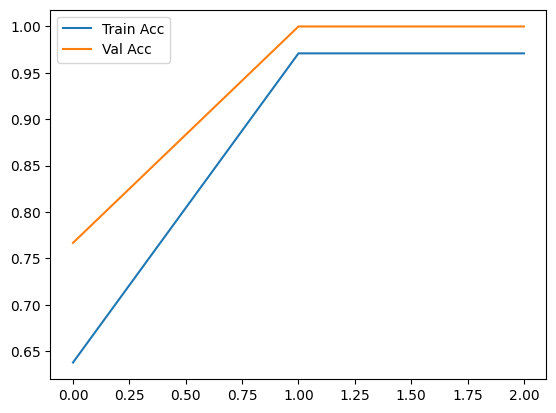

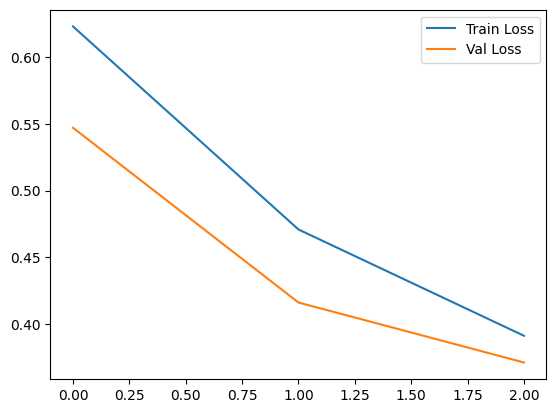

In [11]:
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.legend()
plt.show()

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()


Test evaluation + sample predictions

In [12]:
test_acc, test_loss = eval_model(model, test_loader, loss_fn, device)
print(f"Test loss {test_loss:.4f} accuracy {test_acc:.4f}")

sample = df_test.sample(3)

model.eval()
for i, row in sample.iterrows():
    encoding = tokenizer.encode_plus(
        row.review,
        add_special_tokens=True,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    ids = encoding["input_ids"].to(device)
    mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        out = model(ids, mask)
        probs = torch.softmax(out.logits, dim=1)
        pred = torch.argmax(probs).item()

    print("Review:", row.review)
    print("True:", row.label, "Pred:", pred)
    print("-" * 50)


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Test loss 0.3752 accuracy 1.0000
Review: delicious meal and a wonderful experience overall .
True: 1 Pred: 1
--------------------------------------------------
Review: waiting time was extremely long for a simple order .
True: 0 Pred: 0
--------------------------------------------------
Review: the food arrived cold and tasteless .
True: 0 Pred: 0
--------------------------------------------------
